# Lens modeling of DESIJ1709+3154 with lenstronomy

Author: Anowar Shajib, Tanjela Akter \
Acknowledgement: Robin, Nahid

# Import of standard python libraries


In [ ]:
import corner
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
import yaml
from google.colab import drive
from lenstronomy.Analysis.light_profile import LightProfileAnalysis
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, param_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load imaging data

In [ ]:
with h5py.File("DESIJ1709+3154_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

kwargs_data

{'background_rms': 0.012138557566447335,
 'dec_at_xy_0': -5.239999999999995,
 'exposure_time': array([[359.87256, 438.06912, 395.772  , ..., 419.91418, 398.95667,
         412.0478 ],
        [514.854  , 544.1436 , 447.31396, ..., 445.43423, 523.56964,
         512.79553],
        [364.70517, 475.4317 , 416.52582, ..., 455.95795, 477.7484 ,
         507.18954],
        ...,
        [541.16736, 482.96542, 453.8767 , ..., 407.2749 , 408.97824,
         413.95084],
        [452.9683 , 439.0108 , 417.46097, ..., 568.15814, 551.5595 ,
         480.95288],
        [293.528  , 306.62485, 420.6663 , ..., 379.75095, 417.29932,
         444.0264 ]], dtype=float32),
 'image_data': array([[ 0.01424764,  0.006525  ,  0.00161528, ...,  0.04487504,
          0.05846716,  0.05135536],
        [ 0.0089196 , -0.01107989, -0.02504737, ...,  0.03001957,
          0.04486683,  0.0455122 ],
        [ 0.01499274,  0.0155811 ,  0.00463138, ...,  0.01737003,
          0.05439983,  0.05461017],
        ...,
   

In [ ]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

###Visualizing the data

<ipython-input-12-f3727655582e>:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


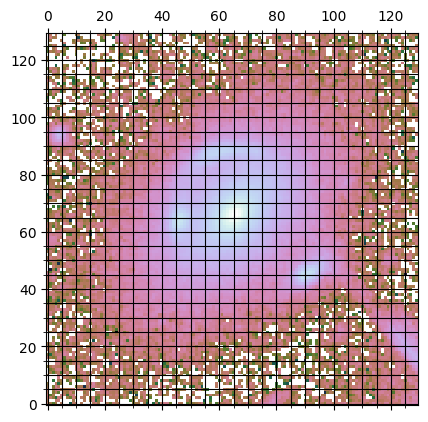

In [ ]:
image_data = kwargs_data["image_data"]
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

## Creating Mask

[[ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 ...
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]] [[-5.24 -5.24 -5.24 ... -5.24 -5.24 -5.24]
 [-5.16 -5.16 -5.16 ... -5.16 -5.16 -5.16]
 [-5.08 -5.08 -5.08 ... -5.08 -5.08 -5.08]
 ...
 [ 4.92  4.92  4.92 ...  4.92  4.92  4.92]
 [ 5.    5.    5.   ...  5.    5.    5.  ]
 [ 5.08  5.08  5.08 ...  5.08  5.08  5.08]]


<ipython-input-13-3ce4ec2773b4>:84: RuntimeWarning: invalid value encountered in log10
  ori = np.log10(kwargs_data["image_data"])
<ipython-input-13-3ce4ec2773b4>:86: RuntimeWarning: divide by zero encountered in log10
  masked_img = np.log10(kwargs_data["image_data"] * mask_img)
<ipython-input-13-3ce4ec2773b4>:86: RuntimeWarning: invalid value encountered in log10
  masked_img = np.log10(kwargs_data["image_data"] * mask_img)
<ipython-input-13-3ce4ec2773b4>:89: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")


Text(0.5, 1.0, 'Masked image')

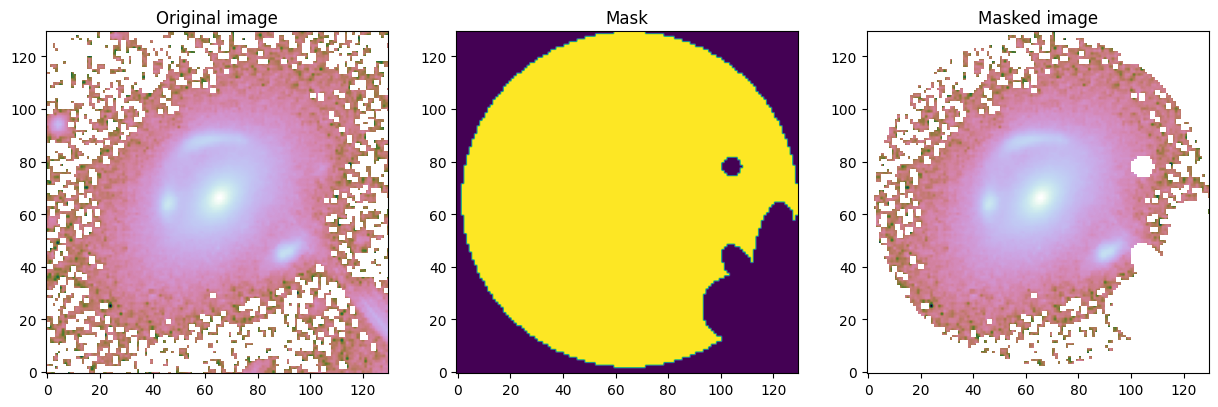

In [ ]:
# To make a likelihood mask using lenstronomy functions,
# here is an example code:


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

print(x_coords, y_coords)

r = 5.1  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.1,
    lens_center_dec + 1,
    0.3,
    0.3,
    0.0,
)


mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.3,
    lens_center_dec - 2.0,
    0.71,
    0.4,
    45,
)

mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.2,
    lens_center_dec - 3.3,
    1.0,
    1,
    15,
)

mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 4.4,
    lens_center_dec - 1.6,
    1.55,
    0.6,
    30,
)


mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
)

mask_img = mask.reshape(num_pix, num_pix)


fig, axs = plt.subplots(1, 3, figsize=(15, 10))

ori = np.log10(kwargs_data["image_data"])

masked_img = np.log10(kwargs_data["image_data"] * mask_img)

plt.sca(axs[0])
plt.imshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")
plt.title("Original image")

plt.sca(axs[1])
plt.imshow(mask_img, origin="lower")
plt.title("Mask")

plt.sca(axs[2])
plt.imshow(masked_img, origin="lower", cmap="cubehelix")
plt.title("Masked image")

## Building the lens model

In [ ]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

### Mass model of the lens galaxy

In [ ]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# setting EPL parameters
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1.5,
        "gamma": 2.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
    }
)

kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 2.0,
        "gamma": 1.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

# Setting SHEAR Parameters
fixed_lens.append({"ra_0": 0, "dec_0": 0})

kwargs_lens_init.append({"gamma1": -0.01, "gamma2": -0.01, "ra_0": 0, "dec_0": 0})

kwargs_lens_sigma.append({"gamma1": 0.1, "gamma2": 0.1, "ra_0": 0, "dec_0": 0})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3, "ra_0": -100, "dec_0": -100})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3, "ra_0": 100, "dec_0": 100})

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

### Light model of the lens galaxy

In [ ]:
# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# 1st sersic

fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 2,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# 2nd sersic

fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "amp": 16,
        "R_sersic": 0.5,
        "n_sersic": 2,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0.0,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

### Light model of the source galaxy

In [ ]:
# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# setting SERSIC_ELLIPSE parameters
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.01,
        "n_sersic": 1.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# setting SHAPELETS parameters
fixed_source.append({"n_max": 8})
kwargs_source_init.append({"beta": 0.03, "center_x": 0.0, "center_y": 0.0})
kwargs_source_sigma.append({"beta": 0.1, "center_x": 0.2, "center_y": 0.2})
kwargs_lower_source.append({"beta": 0.001, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 8, "center_x": 10, "center_y": 10})

joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]


source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

### Combining source and lens models

In [ ]:
# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_source_with_source,
}

### Numerical Settings

In [ ]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask_img]}

kwargs_numerics = {"supersampling_factor": 3, "supersampling_convolution": False}

### Combining all the information to be sent to lenstronomy

In [ ]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

### Model fiting using PSO

In [ ]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

In [ ]:
fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 200, "n_iterations": 200}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.953237866996016 reduced X^2 of best position
-5631.729318212462 log likelihood
11816 effective number of data points
[{'theta_E': 2.00102805034793, 'gamma': 1.7985069680237733, 'e1': 0.048535284978445455, 'e2': -0.1392341208192975, 'center_x': 0.0084910948426613, 'center_y': 0.03170501051195933}, {'gamma1': 0.02474965333755582, 'gamma2': 0.012457172043390566, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.2540857253912715, 'n_sersic': 1.0, 'e1': 0.09772389367726761, 'e2': 0.13399168957187116, 'center_x': -0.3503527988690719, 'center_y': -0.0799601081731488}, {'amp': 1, 'n_max': 8, 'beta': 0.07272489003333112, 'center_x': -0.3503527988690719, 'center_y': -0.0799601081731488}] source result
[{'amp': 1, 'R_sersic': 0.15895495556173697, 'n_sersic': 1.0, 'e1': -0.012883689096339603, 'e2': -0.23289337763421336, 'center_x': -0.007884283935693832, 'cen

### Save the Best Fit Parameters (PSO)

In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "DESIJ1709+3154_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## Visualizing the fitted model (PSO)

-0.947783456760751 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9477834567607505


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
<ipython-input-21-ee76f651caa9>:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


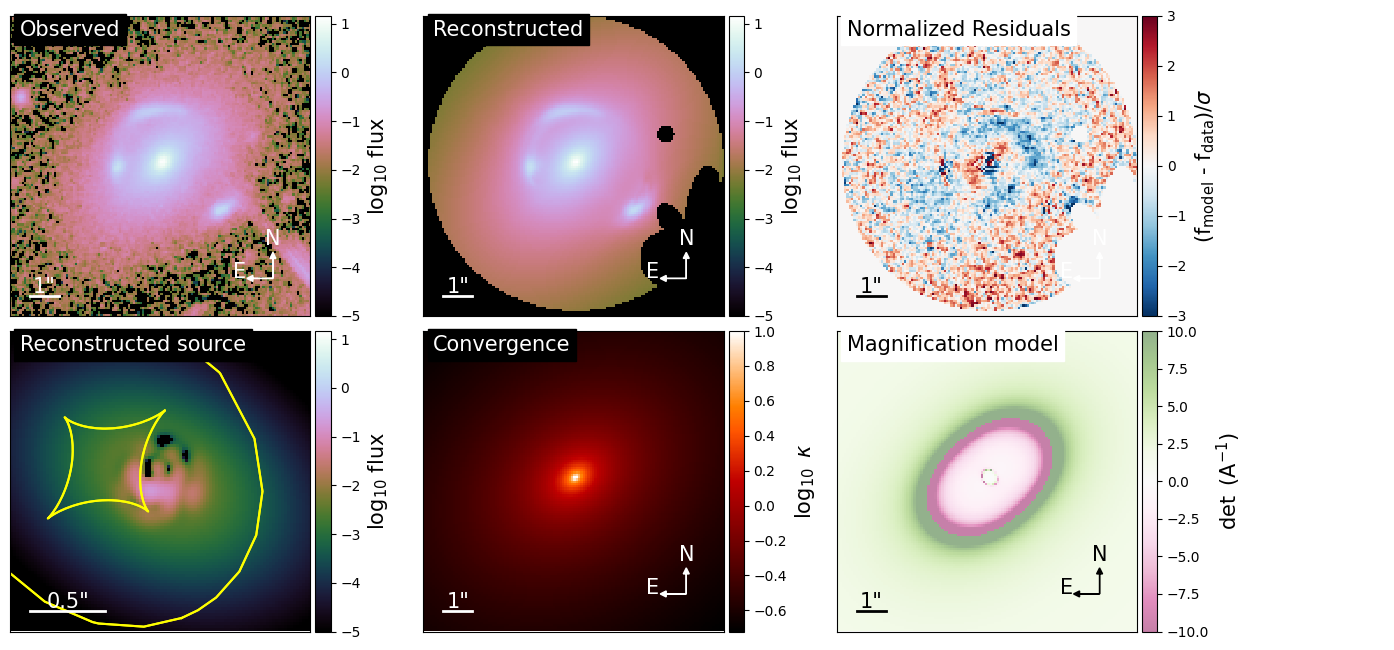

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


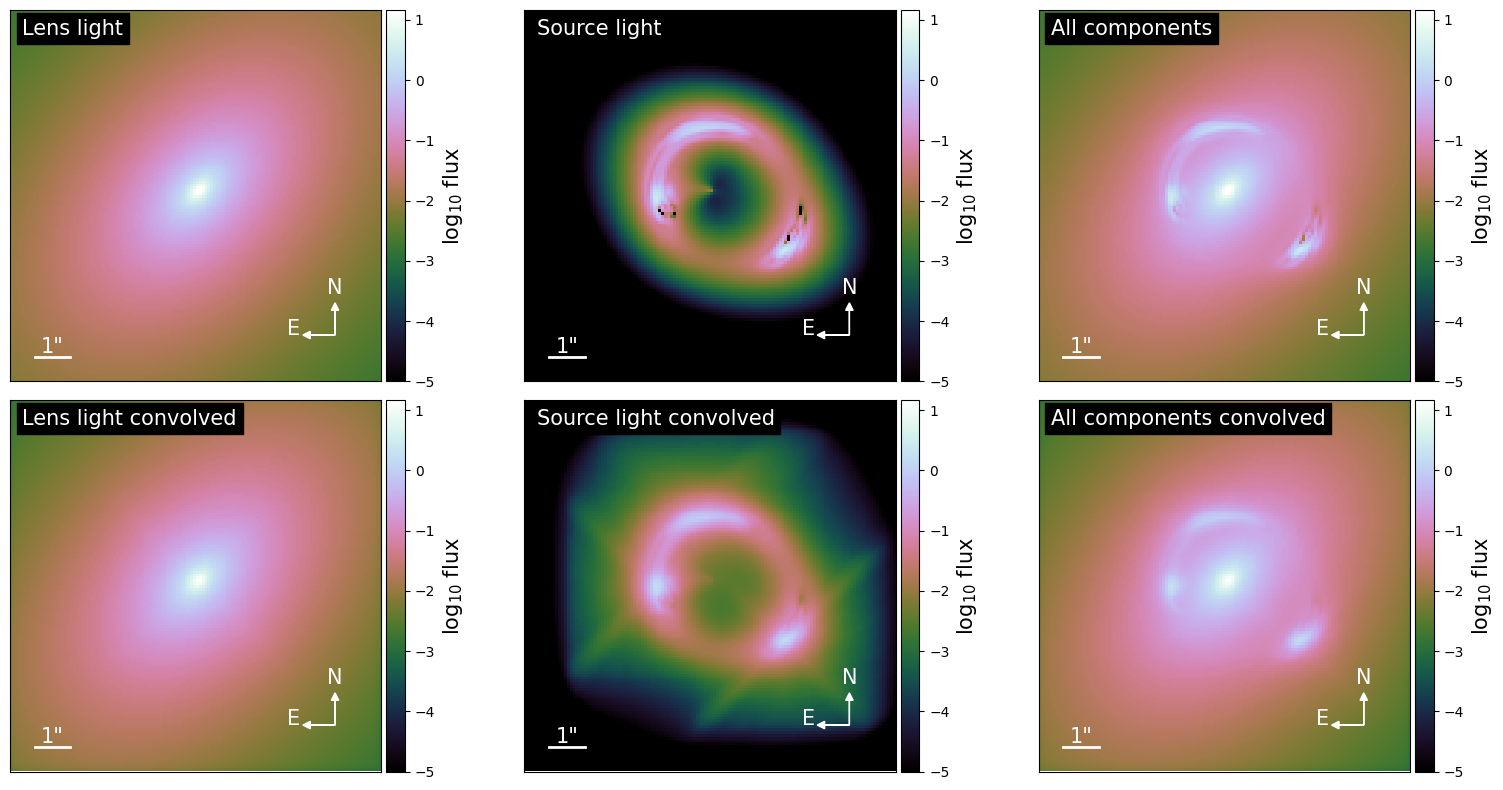

{'kwargs_lens': [{'theta_E': 2.00102805034793, 'gamma': 1.7985069680237733, 'e1': 0.048535284978445455, 'e2': -0.1392341208192975, 'center_x': 0.0084910948426613, 'center_y': 0.03170501051195933}, {'gamma1': 0.02474965333755582, 'gamma2': 0.012457172043390566, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 11.673739243176096, 'R_sersic': 0.2540857253912715, 'n_sersic': 1.0, 'e1': 0.09772389367726761, 'e2': 0.13399168957187116, 'center_x': -0.3503527988690719, 'center_y': -0.0799601081731488}, {'amp': array([ 3.34266087e+02,  1.07212173e+02, -3.82198183e+02,  1.24379220e+02,
       -1.16364207e+02,  1.32582134e+02,  2.86323844e+01, -7.09394684e+01,
        1.35536765e+01,  5.82945245e+01,  2.81153215e+01,  2.33227239e+01,
        3.27716018e+00,  5.55909961e+01, -8.03373664e+01,  8.70370772e+00,
        6.00235198e+01, -6.04159709e+00,  1.23285739e+01, -4.16097181e+01,
       -2.29723588e+01,  1.85338333e+01,  5.48283061e+01, -1.95850924e+01,
       -6.74196564e+00, -4.06846099e-02,

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, with_caustics=True, scale_size=0.5, numPix=100
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

## Model Fitting using MCMC

In [ ]:
# Define the local path to save the backend file:

local_backend_path = "mcmc_backend.h5"

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": 0,
            "n_run": 3,
            "n_walkers": 200,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": local_backend_path,
            "start_from_backend": True,
        },
    ]
]

chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq.best_fit()

100%|██████████| 3/3 [05:41<00:00, 113.97s/it]


Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  0
Sampling iterations (in current run): 3
342.4497911930084 time taken for MCMC sampling


### Trace Plots

<ipython-input-28-ab48d1d40357>:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 2525, N_walkers: 200, N_params: 20
theta_E_lens0 2.0286 ± 0.0048
gamma_lens0 1.7440 ± 0.0189
e1_lens0 0.0579 ± 0.0035
e2_lens0 -0.1831 ± 0.0079
center_x_lens0 0.0230 ± 0.0051
center_y_lens0 0.0486 ± 0.0040
gamma1_lens1 0.0319 ± 0.0024
gamma2_lens1 -0.0235 ± 0.0052
R_sersic_source_light0 0.2684 ± 0.0181
e1_source_light0 0.1080 ± 0.0143
e2_source_light0 0.1864 ± 0.0185
center_x_source_light0 -0.3319 ± 0.0094
center_y_source_light0 -0.0659 ± 0.0056
beta_source_light1 0.0720 ± 0.0021
R_sersic_lens_light0 0.1593 ± 0.0032
e1_lens_light0 -0.0136 ± 0.0013
e2_lens_light0 -0.2349 ± 0.0013
center_x_lens_light0 -0.0081 ± 0.0006
center_y_lens_light0 0.0480 ± 0.0006
R_sersic_lens_light1 1.2254 ± 0.0113


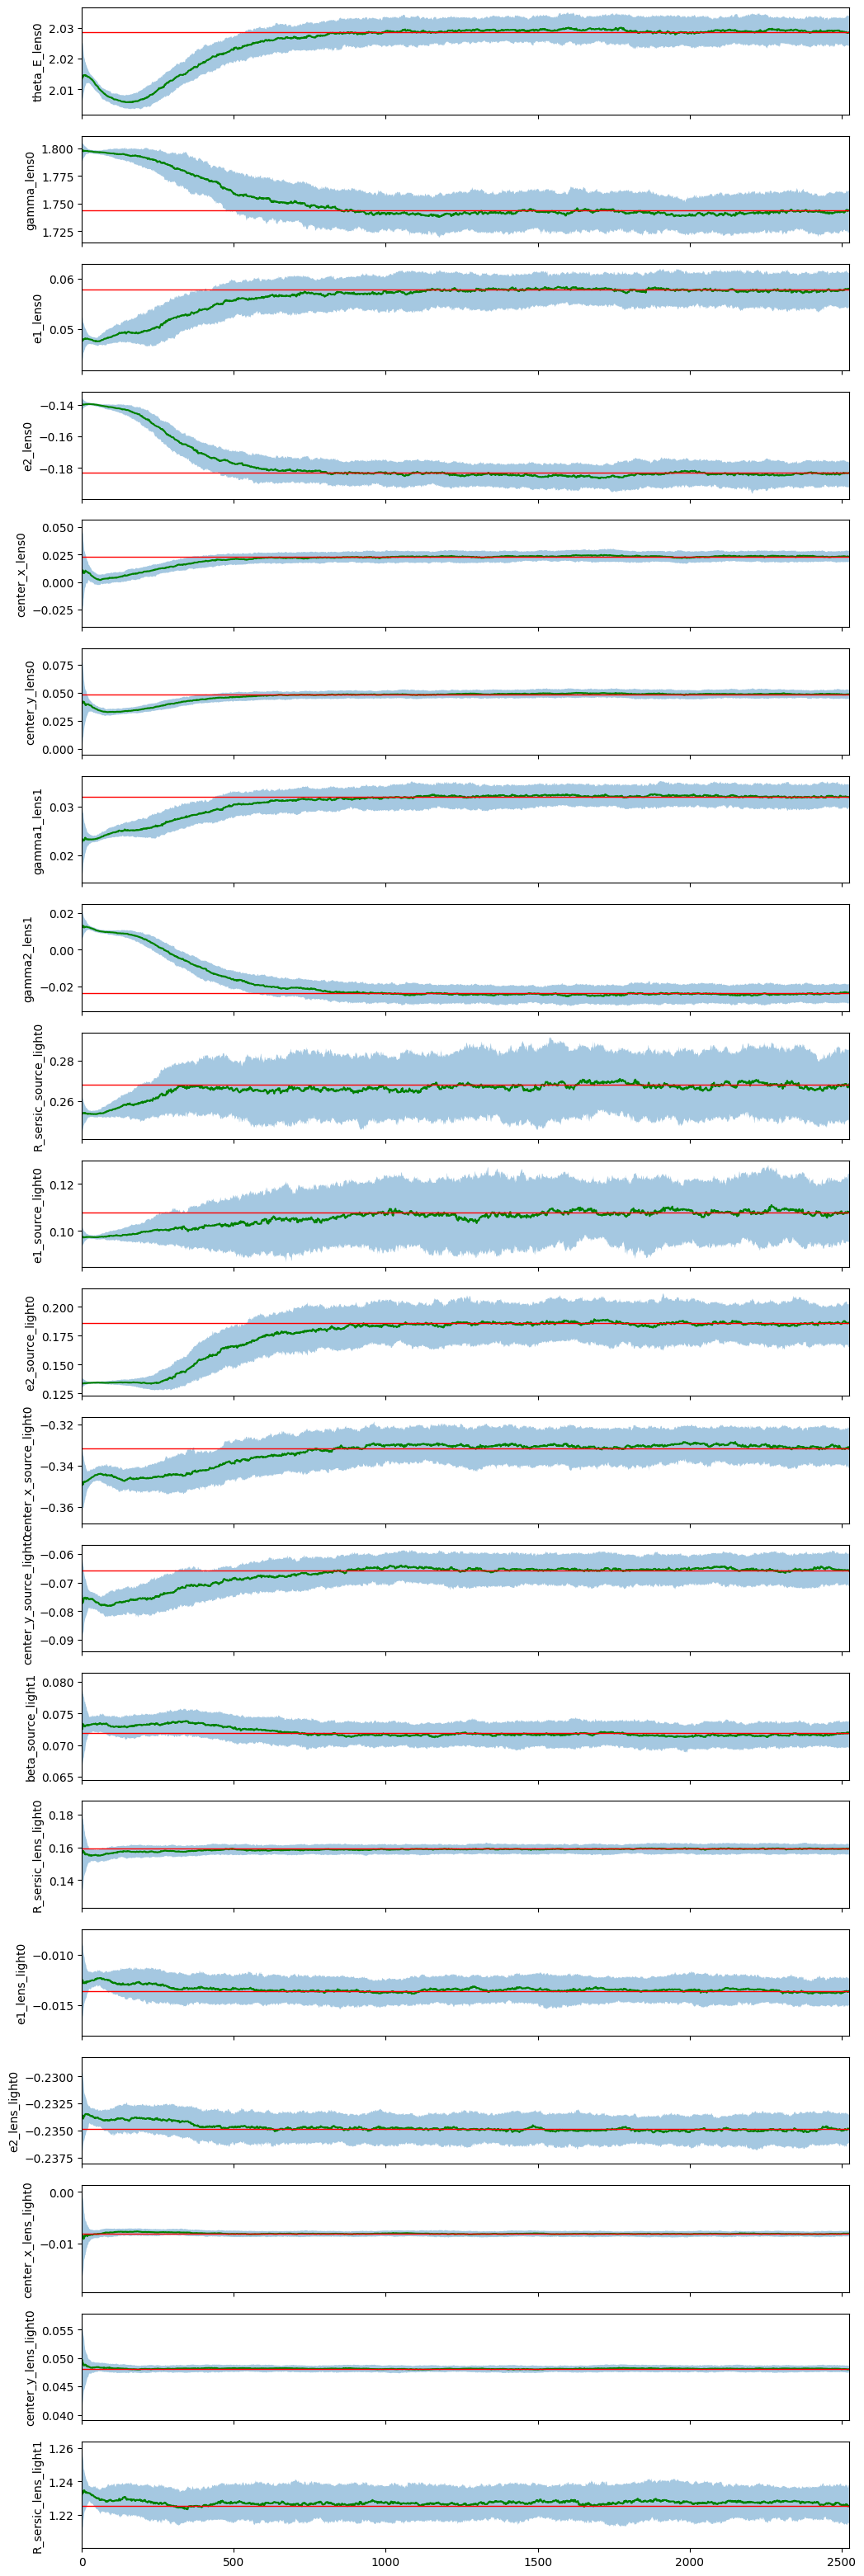

In [ ]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        if samples_mcmc == []:
            samples_mcmc = chain_list_mcmc[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, chain_list_mcmc[k][1]))

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]
    n_walkers = 200
    n_step = int(samples_mcmc.shape[0] / n_walkers)
    n_burn = 0

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )

        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))
    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

### Corner Plots

Number of non-linear parameters in the MCMC process: 20
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Number of evaluations in the MCMC process: 505000
505000
Shape of samples_mcmc_cut: (5400, 20)


<ipython-input-29-c498e5d87cde>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


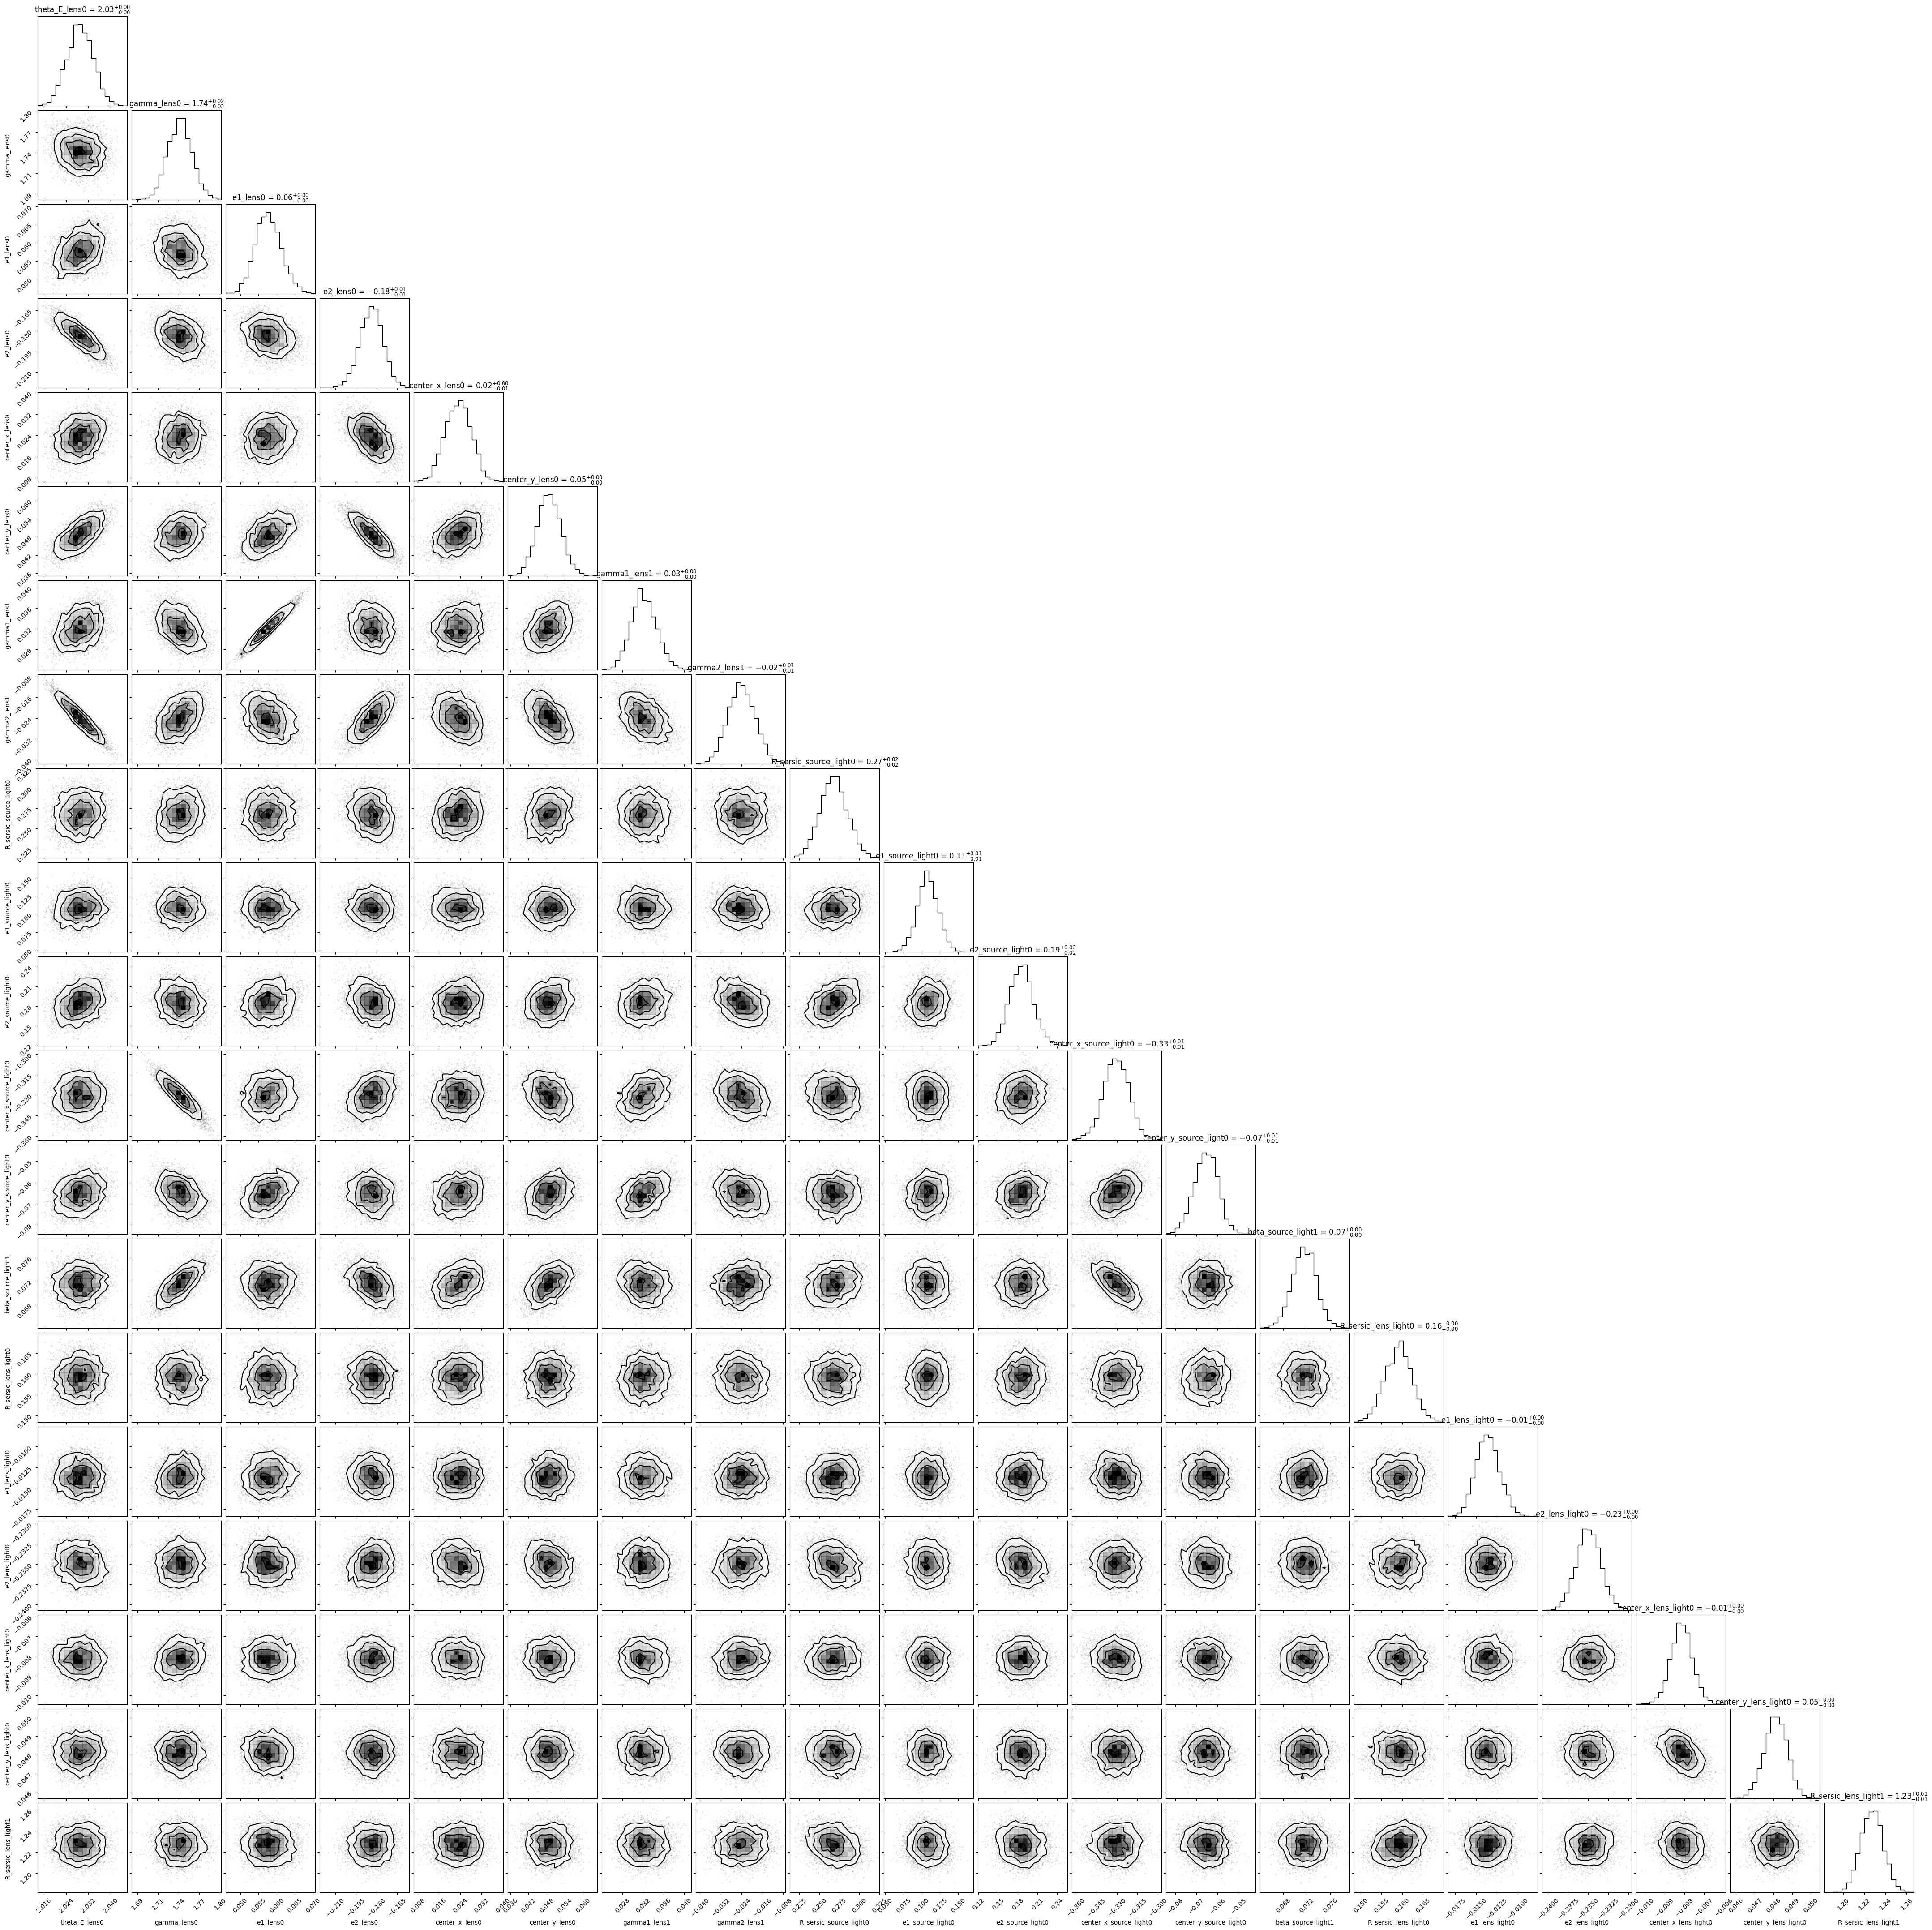

In [ ]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 2000
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

## Visualizing the Fitted Model (MCMC)

-0.943761372830907 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.943761372830907


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),


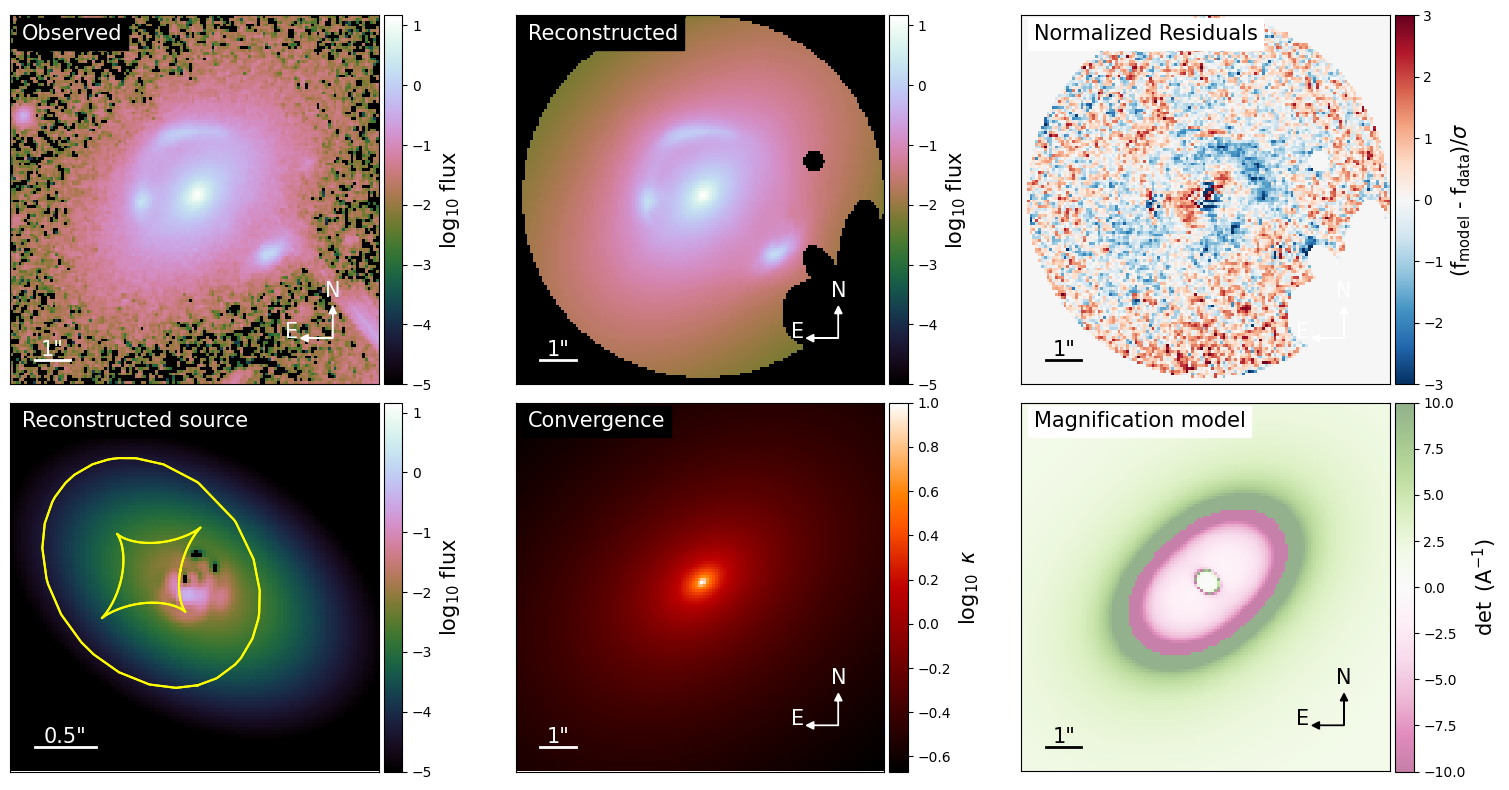

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


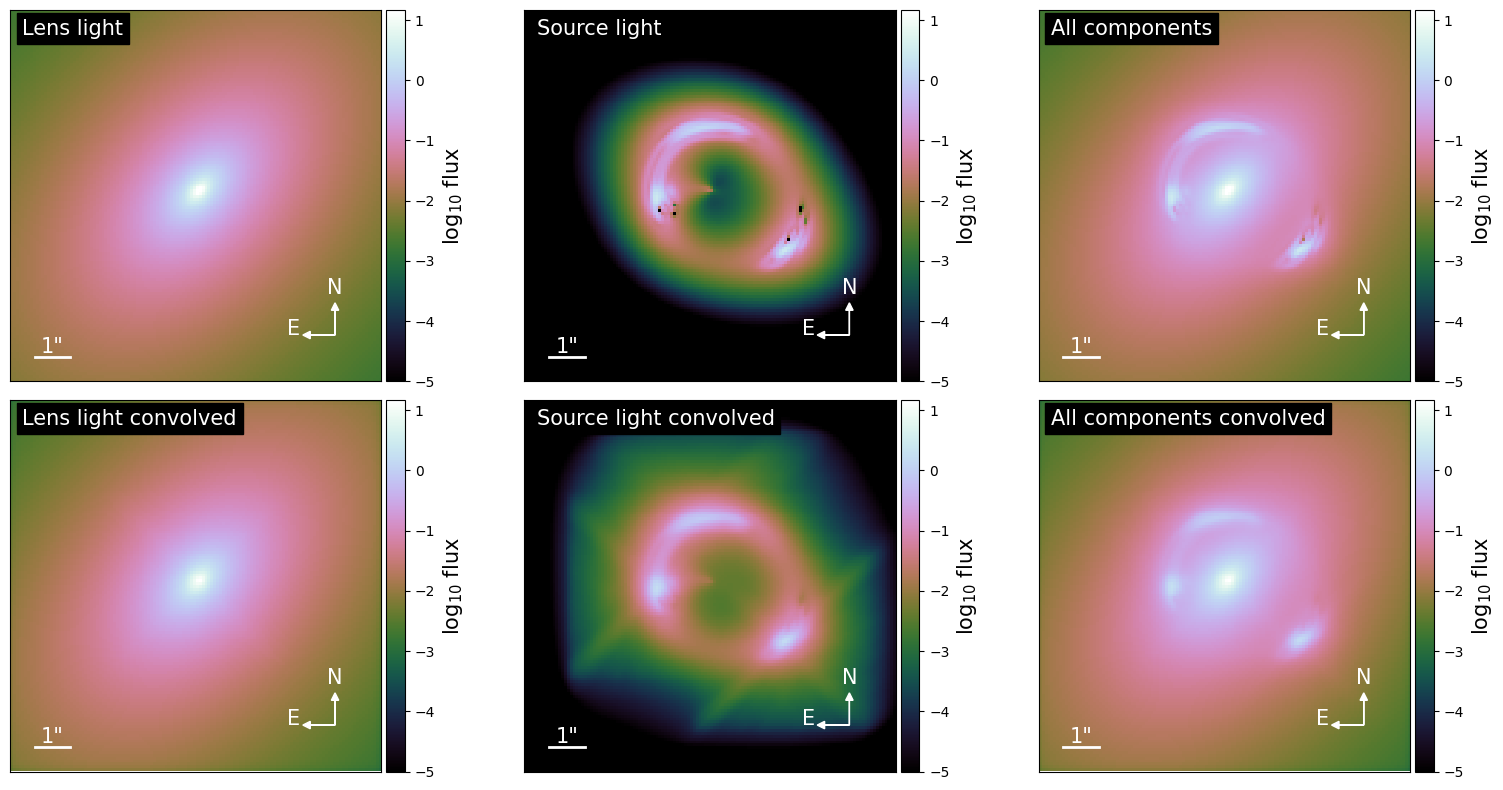

{'kwargs_lens': [{'theta_E': 2.029801582205985, 'gamma': 1.732571904131079, 'e1': 0.059248939392910295, 'e2': -0.18352954979772076, 'center_x': 0.024422666206613937, 'center_y': 0.050042361876394964}, {'gamma1': 0.03339242630048261, 'gamma2': -0.02536871925845223, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 8.516755113884342, 'R_sersic': 0.27047985585531326, 'n_sersic': 1.0, 'e1': 0.10563874489123147, 'e2': 0.18419204229245348, 'center_x': -0.32659969418857376, 'center_y': -0.06393162477308864}, {'amp': array([ 339.53380604,  106.25807138, -376.52290822,  107.31366076,
       -115.25415776,  163.46479722,   21.52992308,  -52.03046914,
         23.74804245,   35.16729099,   27.79426095,   33.47179019,
          1.09351992,   48.10476133,  -74.55426969,   13.495377  ,
         51.28581287,  -18.52231715,    8.20355622,  -40.68333927,
         -7.84283622,   15.70820947,   33.23927842,  -20.76576054,
         -9.11654851,    1.14783534,   -9.52227505,   47.60993037,
        -32.305

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.03, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result_mcmc)

## Mass and Light Ellipticity of the Lens Galaxy


In [ ]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}, \nmass_phi: {}, \nlight_phi: {}".format(
        mass_q, light_q, mass_phi, light_phi
    )
)

mass_q: 0.6766479640988596,
light_q: 0.6180428575049008, 
mass_phi: -0.6292639503892936, 
light_phi: -0.8139037773125584


### Save the Best Fit Parameters (MCMC)

In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

# Defining shortened_samples_mcmc
if samples_mcmc is not None:
    print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    burnin = 2425
    thin = 20
    shortened_samples_mcmc = chain[:, burnin::thin, :].reshape((-1, n_params))
print("Shape of shortened_samples_mcmc:", shortened_samples_mcmc.shape)


output = [
    kwargs_result_mcmc,
    multi_band_list_out,
    kwargs_fixed_out,
    shortened_samples_mcmc,
    param_mcmc,
]

output_path = "DESIJ1709+3154_mcmc_output.joblib"


with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=9)

Number of evaluations in the MCMC process: 505000
505000
Shape of shortened_samples_mcmc: (1000, 20)


### Parameters Without Conversion

In [ ]:
# The list of parameters to be included in the yaml file without conversion
list_params = [
    "theta_E_lens0",
    "gamma_lens0",
    "center_x_lens0",
    "center_y_lens0",
    "center_x_lens_light0",
    "center_y_lens_light0",
]

# Uncertainty calculation
median_sample = np.zeros(n_params)
q16_sample = np.zeros(n_params)
q84_sample = np.zeros(n_params)
values = {}

for i in range(n_params):
    median_sample[i] = np.median(shortened_samples_mcmc[:, i])
    q16_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 16.0)
    q84_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 84.0)

    values[param_mcmc[i]] = [
        median_sample[i],
        q84_sample[i] - median_sample[i],
        median_sample[i] - q16_sample[i],
    ]
# parameters filtered by list params
parameter_values = {k: values.get(k) for k in list_params}
print("\n", parameter_values)  # ['theta_E_lens0'][0])


 {'theta_E_lens0': [2.0289421415345528, 0.004289890410838382, 0.004481129482608814], 'gamma_lens0': [1.7424576180616191, 0.016922292074279532, 0.019055286641057156], 'center_x_lens0': [0.02304583955160497, 0.00514003174057219, 0.004737663145727187], 'center_y_lens0': [0.0487417349793432, 0.0037738898621406947, 0.0039962503671309366], 'center_x_lens_light0': [-0.008162036944126056, 0.0005471574673916613, 0.0005521696485432642], 'center_y_lens_light0': [0.04812940686274823, 0.0006279531823473808, 0.0006155123254884751]}


### Parameters with Conversion

In [ ]:
list_params_prior = [
    "e1_lens0",
    "e2_lens0",
    "gamma1_lens1",
    "gamma2_lens1",
    "e1_lens_light0",
    "e2_lens_light0",
]

list_params_posterior = [
    "phi_mass",
    "q_mass",
    "phi_shear",
    "gamma_shear",
    "phi_light",
    "q_light",
]
n_params_prior = len(list_params_prior)
n_params_posterior = len(list_params_posterior)
length_shortened = len(shortened_samples_mcmc)

prior_samples = np.zeros((length_shortened, n_params_prior))

# Copying the selected (prior) parameters from shortened samples
for j in list_params_prior:
    if j in param_mcmc:
        prior_samples[:, list_params_prior.index(j)] = shortened_samples_mcmc[
            :, param_mcmc.index(j)
        ]
    else:
        print(f"Warning: Parameter '{j}' not found in param_mcmc.")


# Initializing an array for saving the converted parameter values
posterior_samples = np.zeros((length_shortened, n_params_posterior))

for i in range(0, n_params_posterior, 2):
    if i == 0 or i == 4:
        for j in range(length_shortened):
            (
                posterior_samples[j][i],
                posterior_samples[j][i + 1],
            ) = param_util.ellipticity2phi_q(
                prior_samples[j][i], prior_samples[j][i + 1]
            )
    elif i == 2:
        for k in range(length_shortened):
            (
                posterior_samples[k][i],
                posterior_samples[k][i + 1],
            ) = param_util.shear_cartesian2polar(
                prior_samples[k][i], prior_samples[k][i + 1]
            )
            # print(posterior_samples[k][i], posterior_samples[k][i+1])
    else:
        print("Array Index Out of Range")

# Uncertainty calculation
median_sample_posterior = np.zeros(n_params_posterior)
q84_sample_posterior = np.zeros(n_params_posterior)
q16_sample_posterior = np.zeros(n_params_posterior)

values_posterior = {}


for i in range(n_params_posterior):
    median_sample_posterior[i] = np.median(posterior_samples[:, i])
    q16_sample_posterior[i] = np.percentile(posterior_samples[:, i], 16.0)
    q84_sample_posterior[i] = np.percentile(posterior_samples[:, i], 84.0)

    values_posterior[list_params_posterior[i]] = [
        median_sample_posterior[i],
        q84_sample_posterior[i] - median_sample_posterior[i],
        median_sample_posterior[i] - q16_sample_posterior[i],
    ]
# print(values_posterior)
# marge previous parameters and new converted parameters
parameter_values.update(values_posterior)
print(parameter_values)

{'theta_E_lens0': [2.0289421415345528, 0.004289890410838382, 0.004481129482608814], 'gamma_lens0': [1.7424576180616191, 0.016922292074279532, 0.019055286641057156], 'center_x_lens0': [0.02304583955160497, 0.00514003174057219, 0.004737663145727187], 'center_y_lens0': [0.0487417349793432, 0.0037738898621406947, 0.0039962503671309366], 'center_x_lens_light0': [-0.008162036944126056, 0.0005471574673916613, 0.0005521696485432642], 'center_y_lens_light0': [0.04812940686274823, 0.0006279531823473808, 0.0006155123254884751], 'phi_mass': [-0.6337122277743683, 0.011289453770460423, 0.008344906273328623], 'q_mass': [0.6776908323345834, 0.011021811181289976, 0.011932847091485232], 'phi_shear': [-0.3180396402320954, 0.04971479727779338, 0.044211040969564075], 'gamma_shear': [0.04006557670514094, 0.0042100474150017705, 0.003779401346550755], 'phi_light': [-0.8146589333880139, 0.0031815638927142897, 0.0029124253492240904], 'q_light': [0.6190972398787892, 0.0020194370891561952, 0.0019811201089559027]}

### Half-light radius calculation

In [ ]:
light_model = LightModel(lens_light_model_list)
analysis = LightProfileAnalysis(light_model)

# Providing the lens light results from MCMC
kwargs_light = kwargs_result_mcmc["kwargs_lens_light"]

# Calculate the half-light radius
half_light_radius = analysis.half_light_radius(
    kwargs_light, grid_spacing=0.01, grid_num=10 / 0.01
)
print("Half-light radius:", half_light_radius)

# Adding to the dictionary
parameter_values["R_eff_light"] = half_light_radius
print("\n", parameter_values)

Half-light radius: 0.890063589750755

 {'theta_E_lens0': [2.0289421415345528, 0.004289890410838382, 0.004481129482608814], 'gamma_lens0': [1.7424576180616191, 0.016922292074279532, 0.019055286641057156], 'center_x_lens0': [0.02304583955160497, 0.00514003174057219, 0.004737663145727187], 'center_y_lens0': [0.0487417349793432, 0.0037738898621406947, 0.0039962503671309366], 'center_x_lens_light0': [-0.008162036944126056, 0.0005471574673916613, 0.0005521696485432642], 'center_y_lens_light0': [0.04812940686274823, 0.0006279531823473808, 0.0006155123254884751], 'phi_mass': [-0.6337122277743683, 0.011289453770460423, 0.008344906273328623], 'q_mass': [0.6776908323345834, 0.011021811181289976, 0.011932847091485232], 'phi_shear': [-0.3180396402320954, 0.04971479727779338, 0.044211040969564075], 'gamma_shear': [0.04006557670514094, 0.0042100474150017705, 0.003779401346550755], 'phi_light': [-0.8146589333880139, 0.0031815638927142897, 0.0029124253492240904], 'q_light': [0.6190972398787892, 0.00201

### Creating the YAML file

In [ ]:
# Mapping of old parameter names to new parameter names
param_name_mapping = {
    "theta_E_lens0": "theta_E",
    "gamma_lens0": "gamma",
    "center_x_lens0": "center_x_mass",
    "center_y_lens0": "center_y_mass",
    "center_x_lens_light0": "center_x_light",
    "center_y_lens_light0": "center_y_light",
}


# Rename parameters in the parameter_values dictionary
parameter_values = {
    param_name_mapping.get(k, k): v for k, v in parameter_values.items()
}


for key, value in parameter_values.items():
    print(f"{key}: {value}")

theta_E: [2.0289421415345528, 0.004289890410838382, 0.004481129482608814]
gamma: [1.7424576180616191, 0.016922292074279532, 0.019055286641057156]
center_x_mass: [0.02304583955160497, 0.00514003174057219, 0.004737663145727187]
center_y_mass: [0.0487417349793432, 0.0037738898621406947, 0.0039962503671309366]
center_x_light: [-0.008162036944126056, 0.0005471574673916613, 0.0005521696485432642]
center_y_light: [0.04812940686274823, 0.0006279531823473808, 0.0006155123254884751]
phi_mass: [-0.6337122277743683, 0.011289453770460423, 0.008344906273328623]
q_mass: [0.6776908323345834, 0.011021811181289976, 0.011932847091485232]
phi_shear: [-0.3180396402320954, 0.04971479727779338, 0.044211040969564075]
gamma_shear: [0.04006557670514094, 0.0042100474150017705, 0.003779401346550755]
phi_light: [-0.8146589333880139, 0.0031815638927142897, 0.0029124253492240904]
q_light: [0.6190972398787892, 0.0020194370891561952, 0.0019811201089559027]
R_eff_light: 0.890063589750755


Creating the YAML file

In [41]:
# make all the numpy variales to float
parameter_values = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in parameter_values.items()
}

# Write the dictionary to a YAML file
yaml_file_name = "DESIJ1709+3154_point_estimates.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(parameter_values, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

YAML file '/content/drive/MyDrive/Sinthy final del Dec-24 threshold 4/DESIJ1709+3154_point_estimates.yml' created successfully.



Read the YAML file using safe_load

In [43]:
yaml_file_name = "DESIJ1709+3154_point_estimates.yml"
with open(yaml_file_name, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 0.890063589750755, 'Sigma_10': 0.017431404094911365, 'Sigma_10_flux_selected': 0.012829423632370954, 'Sigma_20': 0.019979411547241407, 'Sigma_20_flux_selected': 0.011180264702809693, 'center_x_light': [-0.008162036944126056, 0.0005471574673916613, 0.0005521696485432642], 'center_x_mass': [0.02304583955160497, 0.00514003174057219, 0.004737663145727187], 'center_y_light': [0.04812940686274823, 0.0006279531823473808, 0.0006155123254884751], 'center_y_mass': [0.0487417349793432, 0.0037738898621406947, 0.0039962503671309366], 'gamma': [1.7424576180616191, 0.016922292074279532, 0.019055286641057156], 'gamma_shear': [0.04006557670514094, 0.0042100474150017705, 0.003779401346550755], 'phi_light': [-0.8146589333880139, 0.0031815638927142897, 0.0029124253492240904], 'phi_mass': [-0.6337122277743683, 0.011289453770460423, 0.008344906273328623], 'phi_shear': [-0.3180396402320954, 0.04971479727779338, 0.044211040969564075], 'q_light': [0.6190972398787